## Deep Q-Learning 네트워크(DQN)
* 큐 러닝에 딥러닝 신경망을 적용한 것
* 구글 딥마인드 "Playing Atari with Deep Reinforcement Learning"
<br> - 전통적인 큐러닝의 큐테이블을 딥러닝 신경망으로 대체해서 아타리(Atari) 고전게임을 성공적으로 플레이하는 에이전트를 발표했음
* 큐러닝의 문제점인 관찰 상태와 행동에 큐테이블의 크기가 영향을 받는다는 문제점을 해결함
---
### [2048 게임](https://kil500.tistory.com/236)
* 16개의 타일공간(관찰 상태)에 있는 숫자들을 상하좌우로 움직여서(행동), 2048이라는 숫자를 만드는 것이 목표임
* 게임 규칙
<br> - 게임이 시작할 때 총 2개의 타일이 생성됨 : 90% 확률로 2 숫자타일, 10% 확률로 4 숫자타일
<br> - 상하좌우 4방향으로 게임판의 모든 타일을 움직일 수 있으며, 움직일 때 같은 숫자를 만나면 합쳐짐
<br> - 타일을 합치면 합친만큼의 개수의 새 타일을 얻을 수 있고 점수에도 추가됨
<br> - 타일을 합치거나 이동시키는 등의 유효한 행동을 한 뒤에는 랜덤한 타일 하나가 빈 공간에 생성됨
<br> - 더 이상 타일을 생성할 수 없을 때 게임이 종료됨
---
### 2048 게임을 위한 메모리 공간 크기
* 행동의 개수 : 4 (0:좌, 1:상, 2:우, 3: 하)
* 관찰 공간 수 : 16(4x4)개 x 12가지 = 12^16 = 1.8 x 10^17
<br> - 타일의 종류(12가지) :  0(빈공간), 1, 2, 4, 8, 16, .., 2^10, 2^20 
* 모든 관찰 공간에 대해 Q값을 계산을 위한 총 메모리 필요량
<br> - 관찰 공간의 수 x 행동의 개수 = 2.9 x 10^18 (2.9 EB)
---
### DQN의 장점
* 기존 큐러닝의 단점을 보완
<br> - 전통적인 큐러닝으로 학습할 경우 큐테이블에 저장하고 계산해야 할 양이 너무 많음
<br> - 이런 단점을 보완하기 위해 딥 큐러닝 네트워크로 큐테이블을 대체할 수 있음
* Experience Replay를 사용한 성능 향상
<br> - 큐러닝은 환경을 실행하며 얻어지는 데이터로 즉시 학습했지만, DQN은 별도의 메모리에 데이터를 저장한 뒤에 어느 정도의 데이터가 쌓이면 랜덤한 샘플을 뽑아서 학습시킴

In [1]:
colab = 1
debug = 1

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ln -s /content/drive/MyDrive/lab-rla/ch4/ lab
!ls -l

drive/	lab@  sample_data/


In [4]:
# import tensorflow as tf 
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

In [5]:
# 텐서플로 2 버전 선택
# try:
#     # %tensorflow_version only exists in Colab.
#     %tensorflow_version 2.x
# except Exception:
#     pass
import tensorflow as tf
import numpy as np
print(tf.__version__)

2.5.0


In [6]:
if colab:
    !pip install gym pyvirtualdisplay
    !apt-get install -y xvfb python-opengl ffmpeg

    !apt-get update
    !apt-get install cmake
    !pip install --upgrade setuptools
    !pip install ez_setup
    !pip install gym[atari]

    !pip install box2d-py
    !pip install gym[Box_2D]
else:
#     pip install gym
    pass

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 1,281 kB of archives.
After this operation, 7,686 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 1,281 kB in 1s (1,539 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 160815 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd

  Created wheel for ez-setup: filename=ez_setup-0.9-cp37-none-any.whl size=11014 sha256=c528e5a46374389e55ad878c6d3d05804c142fc6579eff8bdce78cc2a1e21662
  Stored in directory: /root/.cache/pip/wheels/dc/e8/6b/3d5ff5a3efd7b5338d1e173ac981771e2628ceb2f7866d49ad
Successfully built ez-setup
     |████████████████████████████████| 450kB 30.0MB/s 


In [7]:
# gym_2048 설치
!pip install gym_2048 --no-dependencies

  Created wheel for gym-2048: filename=gym_2048-0.2.6-cp37-none-any.whl size=4699 sha256=e4ab4944b6a41f2f549d058ca74373101b8902414481f64520512556b619d18a
  Stored in directory: /root/.cache/pip/wheels/ab/11/22/a6c0fb3622f6fad7e8b7f4342a3c64e115bee08a4189bbae18
Successfully built gym-2048


In [8]:
# 2048 게임 보드의 원-핫 인코딩 함수(알파고)
layer_count = 12
table = {2**i:i for i in range(layer_count)}
print(table)

def preprocess(obs):    
    x = np.zeros((4, 4, layer_count))
    for i in range(4):
        for j in range(4):
            if obs[i,j] > 0:
                v = min(obs[i,j], 2**(layer_count-1))
                x[i,j,table[v]] = 1
            else:
                x[i,j,0] = 1
    return x

{1: 0, 2: 1, 4: 2, 8: 3, 16: 4, 32: 5, 64: 6, 128: 7, 256: 8, 512: 9, 1024: 10, 2048: 11}


### DQN Network 설계
* DQN은 하나가 아닌 2개의 큐네트워크를 사용함 : model, target_model
* 두 네트워크의 구조는 동일함
* Q값 계산식
<br> Q(s,a) = Q(s,a) + a(알파) * (R + r*maxQ(s',a') - Q(s,a))

In [9]:
# 학습 함수 정의
gamma = 0.9
batch_size = 512
max_memory = batch_size*8
memory = []

def train_model():
    np.random.shuffle(memory)

    len = max_memory // batch_size
    for k in range(len):
        mini_batch = memory[k*batch_size:(k+1)*batch_size]

        states = np.zeros((batch_size, 4, 4, layer_count))
        next_states = np.zeros((batch_size, 4, 4, layer_count))
        actions, rewards, dones = [], [], []

        for i in range(batch_size):
            states[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])

        target = model.predict(states)
        next_target = target_model.predict(next_states)

        for i in range(batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                # Q(s,a) = Q(s,a) + a(알파) * (R + r*maxQ(s',a') - Q(s,a))
                target[i][actions[i]] = rewards[i] + gamma * np.amax(next_target[i])

        model.fit(states, target, batch_size=batch_size, epochs=1, verbose=0)

### Data Augmentation
* 하나의 게임보드는 좌우 반전이나 상하 반전, 대각선 반전 등으로 뒤집어도 같은 관찰 대상을 가지는 경우가 많은 원리를 이용함

In [10]:
from tensorflow.keras.models import load_model
model = load_model('lab/2048-conv6-1000.h5')
target_model = load_model('lab/2048-conv6-1000.h5')

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 4, 12)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 3, 4, 128)    3200        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 3, 128)    3200        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 2, 4, 128)    32896       conv2d[0][0]                     
______________________________________________________________________________________________

In [12]:
# for test by SOO
# gym_2048 환경 확인
import gym_2048
import gym

env = gym.make('2048-v0')
obs = env.reset()

print(obs)
obs, _, _, _ = env.step(0)  # 행동의 개수 : 4 (0:좌, 1:상, 2:우, 3: 하)
print(obs)
obs, _, _, _ = env.step(0)
print(obs)
obs, _, _, _ = env.step(0)
print(obs)

[[0 2 0 0]
 [0 0 0 0]
 [2 0 0 0]
 [0 0 0 0]]
[[2 0 0 0]
 [0 0 0 0]
 [2 2 0 0]
 [0 0 0 0]]
[[2 0 0 0]
 [2 0 0 0]
 [4 0 0 0]
 [0 0 0 0]]
[[2 0 0 0]
 [2 0 0 0]
 [4 0 2 0]
 [0 0 0 0]]


/usr/local/lib/python3.7/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


In [13]:
# for test by SOO
g0 = obs
g1 = g0[::-1]
print(g0)
print(g1)

[[2 0 0 0]
 [2 0 0 0]
 [4 0 2 0]
 [0 0 0 0]]
[[0 0 0 0]
 [4 0 2 0]
 [2 0 0 0]
 [2 0 0 0]]


In [14]:
# for test by SOO
g2 = g0[:,::-1]
print(g0)
print(g2)

[[2 0 0 0]
 [2 0 0 0]
 [4 0 2 0]
 [0 0 0 0]]
[[0 0 0 2]
 [0 0 0 2]
 [0 2 0 4]
 [0 0 0 0]]


In [15]:
# for test by SOO
g3 = g2[::-1,:]
print(g0)
print(g3)

[[2 0 0 0]
 [2 0 0 0]
 [4 0 2 0]
 [0 0 0 0]]
[[0 0 0 0]
 [0 2 0 4]
 [0 0 0 2]
 [0 0 0 2]]


In [16]:
# 학습 데이터 보강
max_memory = 512*64

action_swap_array = [[0, 0, 2, 2, 1, 3, 1, 3],
                     [1, 3, 1, 3, 0, 0, 2, 2],
                     [2, 2, 0, 0, 3, 1, 3, 1],
                     [3, 1, 3, 1, 2, 2, 0, 0]]

def append_sample(state, action, reward, next_state, done):
    g0 = state
    g1 = g0[::-1,:,:]
    g2 = g0[:,::-1,:]
    g3 = g2[::-1,:,:]
    r0 = state.swapaxes(0,1)
    r1 = r0[::-1,:,:]
    r2 = r0[:,::-1,:]
    r3 = r2[::-1,:,:]

    g00 = next_state
    g10 = g00[::-1,:,:]
    g20 = g00[:,::-1,:]
    g30 = g20[::-1,:,:]
    r00 = next_state.swapaxes(0,1)
    r10 = r00[::-1,:,:]
    r20 = r00[:,::-1,:]
    r30 = r20[::-1,:,:]

    states = [g0, g1, g2, g3, r0, r1, r2, r3]
    next_states = [g00, g10, g20, g30, r00, r10, r20, r30]

    for i in range(8):
        memory.append([
            states[i],
            action_swap_array[action][i],
            reward,
            next_states[i],
            done
        ])

In [17]:
%%time
# local-gpu : 약 10분 10초  --> ep300
# colab : 약 3분 23초 --> ep100
# DQN 학습 (학습 데이터 보강)
import math
import random
# import gym_2048
# import gym
# env = gym.make('2048-v0')

def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))
    sum_exp_logits = np.sum(exp_logits)
    return exp_logits / sum_exp_logits

max_episodes = 101   # 5001
epsilon = 0.9
epsilon_min = 0.1

scores = []
steps = []
iteration = 0
train_count = 0

for i in range(max_episodes):
    if i % 50 == 0 and i != 0:
        print('score mean:', np.mean(scores[-100:]), 'step mean:', np.mean(steps[-100:]), 'iteration:', iteration, 'epsilon:', epsilon)

    prev_obs = env.reset()

    score = 0
    step = 0
    not_move_list = np.array([1,1,1,1])
    prev_max = np.max(prev_obs)

    while True:
        iteration += 1

        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            x = preprocess(prev_obs)
            logits = model.predict(np.expand_dims(x, axis=0))[0]
            prob = softmax(logits)
            prob = prob * not_move_list
            action = np.argmax(prob)

        obs, reward, done, info = env.step(action)

        score += reward
        step += 1

        # not moved situation
        if reward == 0 and np.array_equal(obs, prev_obs):
            not_move_list[action] = 0
            continue
        else:
            not_move_list = np.array([1,1,1,1])

        # custom reward
        now_max = np.max(obs)
        if prev_max < now_max:
            prev_max = now_max
            reward = math.log(now_max, 2) * 0.1
        else:
            reward = 0

        reward += np.count_nonzero(prev_obs) - np.count_nonzero(obs) + 1

        append_sample(preprocess(prev_obs), action, reward, preprocess(obs), done)

        if len(memory) >= max_memory:
            train_model()
            memory = []

            train_count += 1
            if train_count % 4 == 0:
                target_model.set_weights(model.get_weights())

        prev_obs = obs

#         if epsilon > 0.01 and iteration % 2500 == 0:
        if epsilon > 0.01 and iteration % 200 == 0:
            epsilon = epsilon / 1.005

        if done:
            break

    scores.append(score)
    steps.append(step)

    if i % 50 == 0 and i != 0:
        print(i, 'score:', score, 'step:', step, 'max tile:', np.max(obs), 'memory len:', len(memory))

/usr/local/lib/python3.7/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


score mean: 1027.04 step mean: 116.92 iteration: 5846 epsilon: 0.7788013909428206
50 score: 1048 step: 107 max tile: 128 memory len: 13544
score mean: 1163.76 step mean: 126.44 iteration: 12644 epsilon: 0.6606123379321406
100 score: 1868 step: 177 max tile: 128 memory len: 2136
CPU times: user 2min 47s, sys: 7.57 s, total: 2min 55s
Wall time: 3min 23s


In [18]:
model.save('lab/2048-conv6-aug.h5')

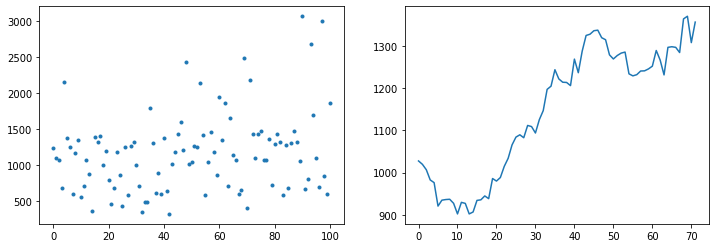

In [19]:
# 점수 확인
import matplotlib.pyplot as plt

N = 30
rolling_mean = [np.mean(scores[x:x+N]) for x in range(len(scores)-N+1)]

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(scores)), scores, marker='.')
plt.subplot(1, 2, 2)
plt.plot(rolling_mean)
plt.show()

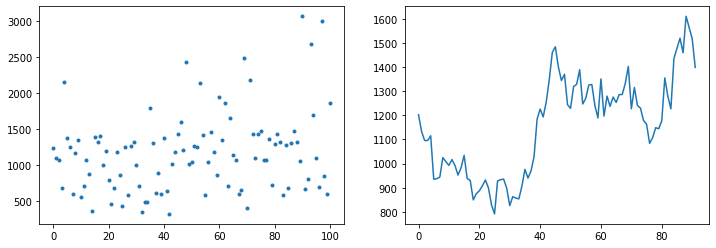

In [20]:
# 점수 확인
import matplotlib.pyplot as plt

N = 10
rolling_mean = [np.mean(scores[x:x+N]) for x in range(len(scores)-N+1)]

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(scores)), scores, marker='.')
plt.subplot(1, 2, 2)
plt.plot(rolling_mean)
plt.show()

### Kernel Restart 후 아래의 게임 테스트 실행

In [21]:
import gym_2048
import gym
import math
import random

from tensorflow.keras.models import load_model
model = load_model('lab/2048-conv6-aug.h5')
target_model = load_model('lab/2048-conv6-aug.h5')
model.summary()
env = gym.make('2048-v0')

def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))
    sum_exp_logits = np.sum(exp_logits)
    return exp_logits / sum_exp_logits

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 4, 12)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 3, 4, 128)    3200        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 3, 128)    3200        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 2, 4, 128)    32896       conv2d[0][0]                     
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


In [22]:
%%time
# local-gpu : 약 10분 30초 --> 100
# colab : 약 4분 12초 --> 30
# 게임 테스트
test_scores = []
max_tile = {}
iteration = 0
train_count = 0

# for i in range(1000):
for i in range(31):
    prev_obs = env.reset()

    score = 0
    step = 0
    not_move_list = np.array([1,1,1,1])

    while True:
        iteration += 1

        x = preprocess(prev_obs)
        logits = model.predict(np.expand_dims(x, axis=0))[0]
        prob = softmax(logits)
        prob = prob * not_move_list
        action = np.argmax(prob)

        obs, reward, done, info = env.step(action)

        score += reward
        step += 1

        # not moved situation
        if reward == 0 and np.array_equal(obs, prev_obs):
            not_move_list[action] = 0
            continue
        else:
            not_move_list = np.array([1,1,1,1])

        prev_obs = obs

        if done:
            now_max = np.max(obs)
            max_tile[now_max] = max_tile.get(now_max, 0) + 1
            break

    test_scores.append(score)
    print(i, 'score:', score, 'step:', step, 'max tile:', np.max(obs))    

print(max_tile)

/usr/local/lib/python3.7/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


0 score: 1340 step: 140 max tile: 128
1 score: 1192 step: 136 max tile: 64
2 score: 3144 step: 258 max tile: 256
3 score: 1684 step: 173 max tile: 128
4 score: 3112 step: 262 max tile: 256
5 score: 1536 step: 157 max tile: 128
6 score: 2956 step: 250 max tile: 256
7 score: 2444 step: 209 max tile: 256
8 score: 1604 step: 154 max tile: 128
9 score: 2932 step: 248 max tile: 256
10 score: 1288 step: 133 max tile: 128
11 score: 1432 step: 141 max tile: 128
12 score: 2144 step: 202 max tile: 128
13 score: 3088 step: 256 max tile: 256
14 score: 5336 step: 374 max tile: 512
15 score: 1408 step: 136 max tile: 128
16 score: 1284 step: 131 max tile: 128
17 score: 3292 step: 265 max tile: 256
18 score: 2308 step: 192 max tile: 256
19 score: 1088 step: 128 max tile: 64
20 score: 664 step: 91 max tile: 64
21 score: 3108 step: 258 max tile: 256
22 score: 1360 step: 140 max tile: 128
23 score: 1328 step: 137 max tile: 128
24 score: 3076 step: 254 max tile: 256
25 score: 2192 step: 209 max tile: 128
2